In [3]:
import torch
import torchvision as tv 
from torchvision import datasets, transforms
import torch.nn as nn 
from torch.nn import functional as F

import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt 

import os
from tqdm import tqdm

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [17]:
train_dir = './drive/MyDrive/Colab Notebooks/Training_Images'
test_dir = './drive/MyDrive/Colab Notebooks/Testing_Images'

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 32
classes = 5
input_shape = (3, 224, 224)

epochs = 50

In [6]:
train_transforms = transforms.Compose(
    [
     transforms.RandomRotation(30),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor()
    ]
)

val_transforms = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)

In [18]:
trainData = datasets.ImageFolder(train_dir, transform = train_transforms)
testData = datasets.ImageFolder(test_dir, transform = test_transforms)

l_data = len(trainData)

class_dict=trainData.class_to_idx
class_labels = class_dict.values()

train_split = int(0.8*l_data)
val_split = l_data - train_split

trainData, valData = torch.utils.data.random_split(trainData, [train_split, val_split])

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = batch_size, shuffle = True)
valLoader = torch.utils.data.DataLoader(valData, batch_size = batch_size, shuffle = True)
testLoader = torch.utils.data.DataLoader(testData, batch_size = batch_size, shuffle = True)

In [19]:
def plot_random_sample(loader):
    iterate = iter(loader)
    iternext = next(iterate)
    img, lab = iternext
    fig, ax = plt.subplots(3, 3, figsize = (10, 10), )
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(img[j + 3*i].permute(2, 1, 0))
            ax[i][j].set_title(lab[j + 3*i].item(), fontsize = 15)
    
    plt.show()

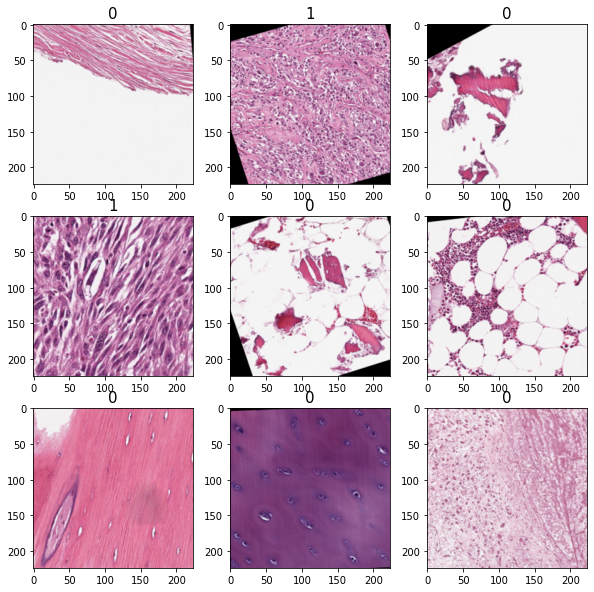

In [20]:
plot_random_sample(trainLoader)

In [21]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 5) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
def accuracy(prediction, label):
    n_correct = 0
    n_samples = 0
    _, preds = prediction.max(1)
    n_correct += (preds == label).sum()
    n_samples = preds.size(0)

    return n_correct/n_samples

In [23]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained = True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [24]:
AlexNet_model.classifier[4] = nn.Linear(4096, 1024)
AlexNet_model.classifier[6] = nn.Linear(1024, 5)

In [25]:
AlexNet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
import torch.optim as optim
import torch.nn as nn

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

In [27]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

Finished Training of AlexNet


In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: %d %%' % (
    100 * correct / total))

Accuracy of the network: 83 %


In [30]:
torch.save(AlexNet_model, './bone-diagnosis.pt')